In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
x = cv2.imread("/kaggle/input/tests-for-ensambling/test_R/31252.jpg", cv2.IMREAD_COLOR)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = cv2.resize(x, (256, 256))
test_R = x/255.0

IMAGE_SIZE = 256
y = cv2.imread("/kaggle/input/tests-for-ensambling/test_D/31252.png", cv2.IMREAD_GRAYSCALE)
y = cv2.resize(y, (IMAGE_SIZE, IMAGE_SIZE))
y = np.expand_dims(y, axis=-1)
test_D = y/255.0

# > ****Custumated Loss function used for Abdullah's & Khubaib model****

In [3]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IoU_loss(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return 1 - (intersection + 1) / (union + 1)
def RMSE_loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true, y_pred)

def combined_loss(y_true, y_pred):
    combined_loss = dice_loss(y_true, y_pred) + RMSE_loss(y_true, y_pred) + IoU_loss(y_true, y_pred)
    return combined_loss

# > ****Custumated Loss function used for Fizan model****

In [4]:
def iou_loss(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return 1 - (intersection + 1) / (union + 1)
delta = 1.0
def HUBER_Loss(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < delta
  squared_loss = tf.square(error) / 2
  linear_loss = delta * tf.abs(error) - delta**2 / 2
  return tf.where(is_small_error, squared_loss, linear_loss)
def combined_loss_2(y_true, y_pred):
    combined_loss = dice_loss(y_true, y_pred) + HUBER_Loss(y_true, y_pred) + iou_loss(y_true, y_pred)
    return combined_loss

In [5]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

Abdullah = load_model('/kaggle/input/models-2/Models/Abdullah_Model.h5',custom_objects={'combined_loss': combined_loss,'RMSE_loss':RMSE_loss,'IoU_loss':IoU_loss,'dice_loss':dice_loss,'dice_coef':dice_coef})

Khubaib = load_model('/kaggle/input/khubaibs-model/Hubaib_HK_Model.h5',custom_objects={'combined_loss': combined_loss,'RMSE_loss':RMSE_loss,'IoU_loss':IoU_loss,'dice_loss':dice_loss,'dice_coef':dice_coef})

Faizan = load_model('/kaggle/input/models-2/Models/FF.h5',custom_objects={'combined_loss': combined_loss_2,'HUBER_Loss':HUBER_Loss,'iou_loss':iou_loss,'dice_loss':dice_loss,'dice_coef':dice_coef})

models = [Abdullah, Khubaib, Faizan] 

2023-01-05 11:19:57.798499: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
preds = [model.predict(np.expand_dims(test_R, axis=0)) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)
ensemble_prediction = summed[0]

2023-01-05 11:20:18.303538: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
prediction1 = Abdullah.predict(np.expand_dims(test_R, axis=0))[0]
prediction2 = Khubaib.predict(np.expand_dims(test_R, axis=0))[0]
prediction3 = Faizan.predict(np.expand_dims(test_R, axis=0))[0]

In [8]:
ensemble_prediction = np.mean( np.array([ prediction1,prediction2,prediction3 ]), axis=0 )

In [9]:
accuracy1 = dice_coef(test_D, prediction1)
accuracy2 = dice_coef(test_D, prediction2)
accuracy3 = dice_coef(test_D, prediction3)

accuracy1 = accuracy1.numpy()
accuracy2 = accuracy2.numpy()
accuracy3 = accuracy3.numpy()

ensemble_accuracy = dice_coef(test_D, ensemble_prediction)
ensemble_accuracy = ensemble_accuracy.numpy()

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model1 =  0.48838598
Accuracy Score for model2 =  0.48530036
Accuracy Score for model3 =  0.4782041
Accuracy Score for average ensemble =  0.48399493


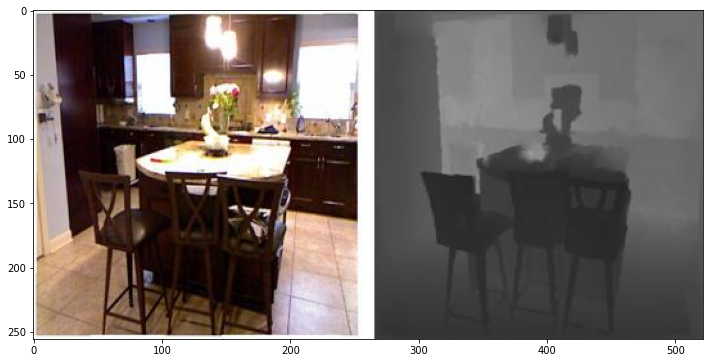

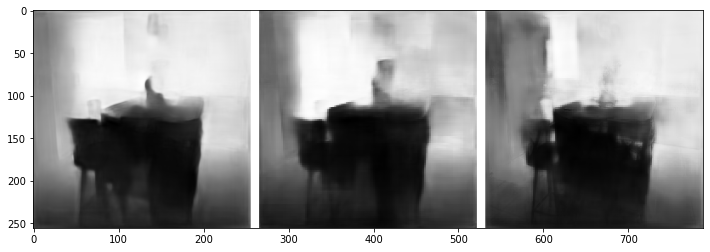

In [10]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

prediction1= (prediction1 - prediction1.min()) / (prediction1.max() - prediction1.min())
prediction2= (prediction2 - prediction2.min()) / (prediction2.max() - prediction2.min())
prediction3= (prediction3 - prediction3.min()) / (prediction3.max() - prediction3.min())

h, w, _ = test_R.shape
white_line = np.ones((h, 10, 3))

Test_images = [
    test_R, white_line,
    mask_parse(test_D),
]

predected_images = [
    mask_parse(prediction1),white_line,
    mask_parse(prediction2),white_line,
    mask_parse(prediction3) 
]

image = np.concatenate(Test_images, axis=1)
fig = plt.figure(figsize=(12, 12))
imgplot = plt.imshow(image)

prediction = np.concatenate(predected_images, axis=1)
fig = plt.figure(figsize=(12, 12))
imgplot = plt.imshow(prediction)

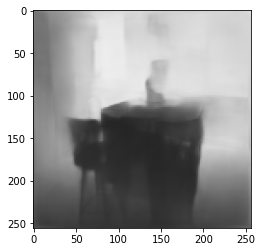

<Figure size 864x864 with 0 Axes>

In [11]:
ensambled_image = mask_parse(ensemble_prediction)
imgplot = plt.imshow(ensambled_image)
fig = plt.figure(figsize=(12, 12))